In [11]:
import numpy as np
import scipy.linalg as la
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.patches import Rectangle

import inverted_pendulum_on_cart
import control as ct

np.set_printoptions(precision=2)

## Simulation

In [16]:
 # Parameters:
M = 10.
m = 80.
J = 100.
c = 0.1
ell = 1.
gamma = 0.01
g = 9.8

# Run simulation for tf seconds
tf = 10.  

# Initial conditions
theta0 = 0
x0 = 0.
IC = np.array([x0, theta0, 0, 0.])  # Initial condition

# Step input
f = 1.

# Run the simulation
t = np.linspace(0, tf, 100)
trajectory = odeint(inverted_pendulum_on_cart.Model, IC, t, args=(M, m, J, g, ell, c, gamma, f),
               rtol=1e-4, atol=1e-5)

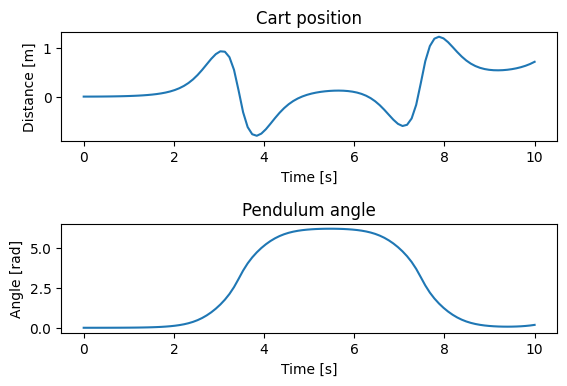

In [17]:
# Plot the data

fig, axs = plt.subplots(2,1)

# plot the cart position
axs[0].plot(t,trajectory[:,0])
# plot the pendulum angle
axs[1].plot(t,trajectory[:,1])

# Format the plot
axs[0].set_title("Cart position")
axs[0].set_ylabel('Distance [m]')
axs[0].set_xlabel('Time [s]')

axs[1].set_title("Pendulum angle")
axs[1].set_ylabel('Angle [rad]')
axs[1].set_xlabel('Time [s]')

axs[0].set_position([0.125, 0.75, 0.775, 0.227])
axs[1].set_position([0.125, 0.35, 0.775, 0.227])

# Cart pendulum linearized

In [180]:
# State space: (x, theta, xdot, thetadot)

# for convenience
M_t = M+m;
J_t = J + m*ell**2

mu = M_t*J_t - m**2*ell**2

A = np.array([[0, 0, 1, 0],
            [0, 0, 0, 1],
            [0, (m**2*ell**2*g)/mu, (-c*J_t)/mu, -(gamma*ell*m)/mu],
            [0, (M_t*m*g*ell)/mu, (-c*ell*m)/mu, -(gamma*M_t)/mu]])

B = np.array([0, 0, J_t/mu, (ell*m)/mu ]).reshape(4, 1)

C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

D = np.zeros([2,1])

### Check Reachability

In [181]:
# compute the controllability matrix
ctrb_matrix = ct.ctrb(A, B)

# check if the matrix is full column rank, ie, if rank(matrix)=number of columns

ctrb_result = True if np.linalg.matrix_rank(ctrb_matrix) == ctrb_matrix.shape[1] else False
print('Is Reachable: ',ctrb_result)

Is Reachable:  True


### Reachability Grammian

In [182]:
# uncontrolled system
sys = ct.ss(A,B,C,D)

# compute the observability grammian
Wo = ct.gram(sys_c, 'c')

# volume of the reachability grammian ellipsoid
print('Volume of reachability grammian ellipsoid: ', np.linalg.det(Wo)) 

# eigenvalues of the reachability grammian 
print('Eigenvalues of reachability grammian: ', np.linalg.eigvals(Wo))

Volume of reachability grammian ellipsoid:  1.2047571181545106e-17
Eigenvalues of reachability grammian:  [1.58e-03 4.86e-04 2.39e-06 6.56e-06]


### Check open loop stability

In [183]:
eigs = np.linalg.eigvals(A)

ctrb_result = True if np.all(eigs.real<0) else False
print('Is stable: ',ctrb_result)
print('Real part of Eigenvalues: ', eigs.real)

Is stable:  False
Real part of Eigenvalues:  [ 0.00e+00  2.68e+00 -2.68e+00 -1.11e-03]


# Designing a controller with state feedback

1. We notice that the closed loop controller will consist of 2 sub-controllers: a fast controller to stabilize the inverted pendulum and a slower controller to control the position of the cart
2. To design fast controller for the pendulum, we first look at it's natural frequency (hanging-down position)

In [184]:
p_omega_n = np.sqrt((m*g*ell)/J_t)
print("Pendulum natural frequency: ", p_omega_n, "rad/s") 

Pendulum natural frequency:  2.086996778999804 rad/s


We choose $\zeta=0.5$ for a fast response. With the values of $\omega_n$ and $\zeta$, we can compute the desired closed loop eigenvalues

In [185]:
# desired parameter
p_zeta= 0.5

# compute eigenvalues for the desired system  
coeff = [1., 2.*p_zeta*p_omega_n, p_omega_n**2]
pendulum_eig = np.roots(coeff)

print("Desired eigenvalues for pendulum dynamics: ", pendulum_eig)

Desired eigenvalues for pendulum dynamics:  [-1.04+1.81j -1.04-1.81j]


1. For the slower controller for the cart, we choose $\zeta=1/\sqrt{2}$ to have a smaller overshoot (just $4 \%$)
2. The choice of natural frequency determines the rise time:  $Rise \ time = \frac{2.2}{\omega_n}$ for $\zeta=1/\sqrt{2}$. We require a rise time of about 5$s$

In [186]:
# desired parameters
c_zeta= 1/ np.sqrt(2)
c_t_rise = 5.

c_omega_n = 2.2/c_t_rise

# compute eigenvalues for the desired system  
coeff = [1., 2.*c_zeta*c_omega_n, c_omega_n**2]
cart_eig = np.roots(coeff)

print("Desired eigenvalues for cart dynamics: ", cart_eig)

Desired eigenvalues for cart dynamics:  [-0.31+0.31j -0.31-0.31j]


1. Having computed all the desired eigenvalues, we compute the gain matrix $K$

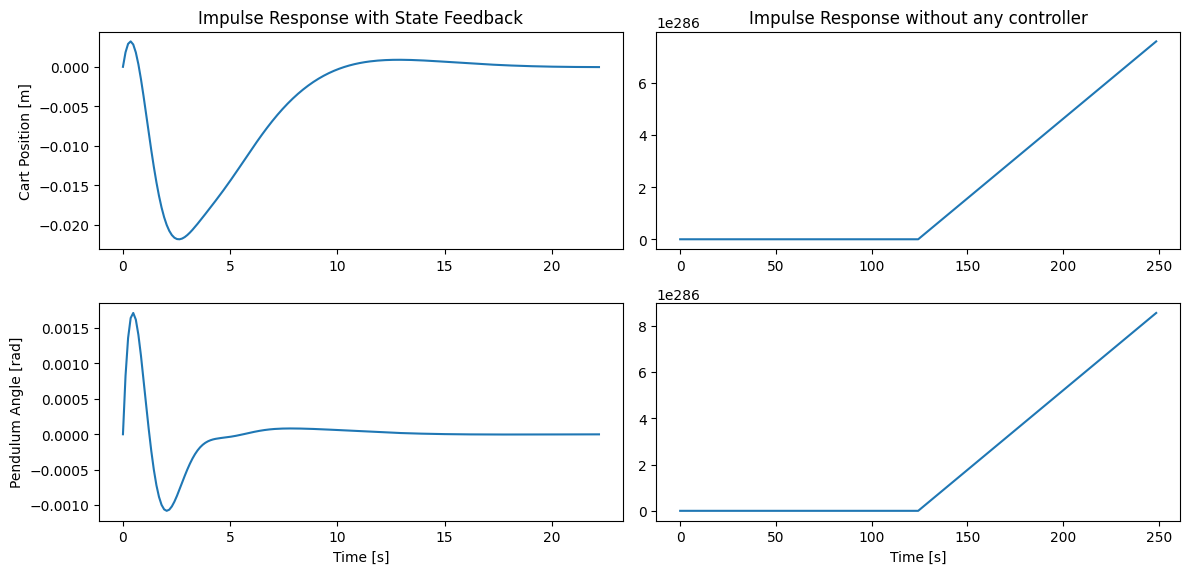

In [187]:
# combine the desired eigenvalues for the cart and pendulum dynamics intro a single vector
desired_eig = np.concatenate((pendulum_eig,cart_eig), axis=0)

# compute gain matrix K such that (A-BK) has the desired eigenvalues 
K = ct.place(A, B, desired_eig)

# compute new dynamics matrix with state feedback: (A-BK)
A_state_fb = A - np.matmul(B,K)

# controlled system
sys_c = ct.ss(A_state_fb,B,C,D)
T_c, yout_c = ct.impulse_response(sys_c)

# uncontrolled system
sys_uc = ct.ss(A,B,C,D)
T_uc, yout_uc = ct.impulse_response(sys_uc)

# Plot the data
fig, axs = plt.subplots(2,2,figsize=(12, 6))

# impulse reponse of the controlled system
axs[0,0].plot(T_c.reshape(T_c.size,1), yout_c[0].T)
axs[1,0].plot(T_c.reshape(T_c.size,1), yout_c[1].T)

# impulse reponse of the uncontrolled system
axs[0,1].plot(T_uc.reshape(T_uc.size,1), yout_uc[0].T)
axs[1,1].plot(T_uc.reshape(T_uc.size,1), yout_uc[1].T)

# Format the plot
axs[0,0].set_title("Impulse Response with State Feedback")
axs[0,0].set_ylabel('Cart Position [m]')
axs[1,0].set_ylabel('Pendulum Angle [rad]')
axs[1,0].set_xlabel('Time [s]')

axs[0,1].set_title("Impulse Response without any controller")
axs[1,1].set_xlabel('Time [s]')

plt.tight_layout()

### Adding feedforward gain

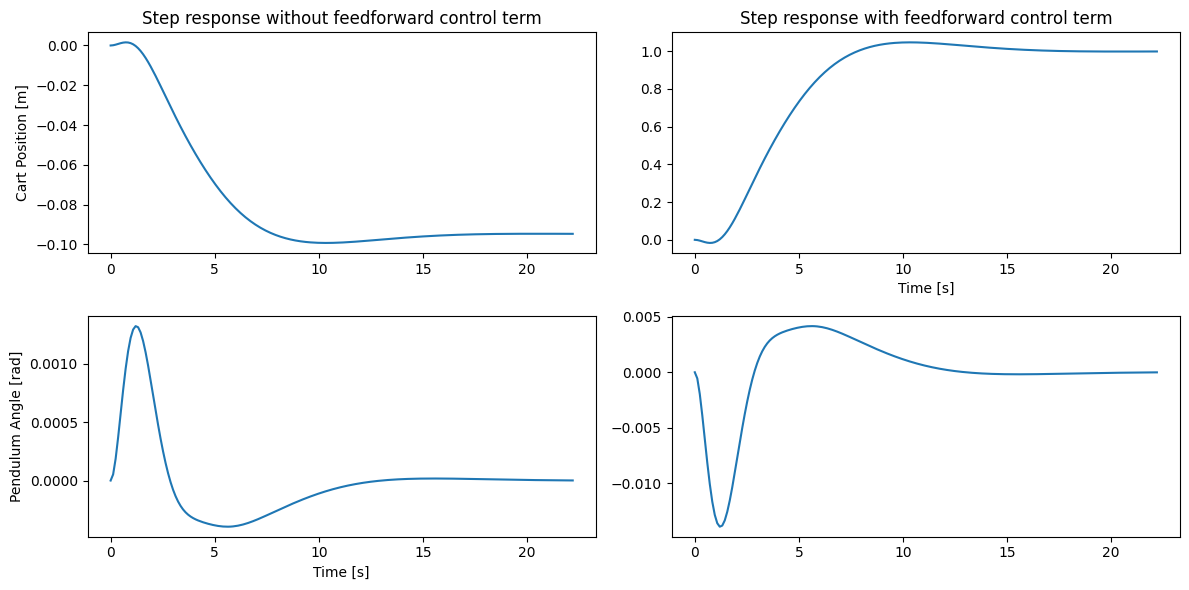

In [188]:
# comput DC gain (gain at zero input frequency)
dc_gain = sys_c(0)

# compute k_f
k_f = np.real(1/dc_gain[0])

# controlled system with feedforward gain
sys_cff = ct.ss(A_state_fb, B*k_f, C, D)

# step response of controlled system without feedforward gain
T_c, yout_c = ct.step_response(sys_c)

# step response of controlled system with feedforward gain
T_cff, yout_cff = ct.step_response(sys_cff)

# Plot the data
fig, axs = plt.subplots(2,2, figsize=(12, 6))

# step reponse of the controlled system
axs[0,0].plot(T_c.reshape(T_c.size,1), yout_c[0].T)
axs[1,0].plot(T_c.reshape(T_c.size,1), yout_c[1].T)

# step reponse of the uncontrolled system
axs[0,1].plot(T_cff.reshape(T_cff.size,1), yout_cff[0].T)
axs[1,1].plot(T_cff.reshape(T_cff.size,1), yout_cff[1].T)

# Format the plot
axs[0,0].set_title("Step response without feedforward control term")
axs[0,0].set_ylabel('Cart Position [m]')
axs[1,0].set_ylabel('Pendulum Angle [rad]')
axs[1,0].set_xlabel('Time [s]')

axs[0,1].set_title("Step response with feedforward control term")
axs[0,1].set_xlabel('Time [s]')
plt.tight_layout()

We see that the performance criterion of rise time = 5s has indeed been satisfied. But let's consider the input forces required to achieve this performance 

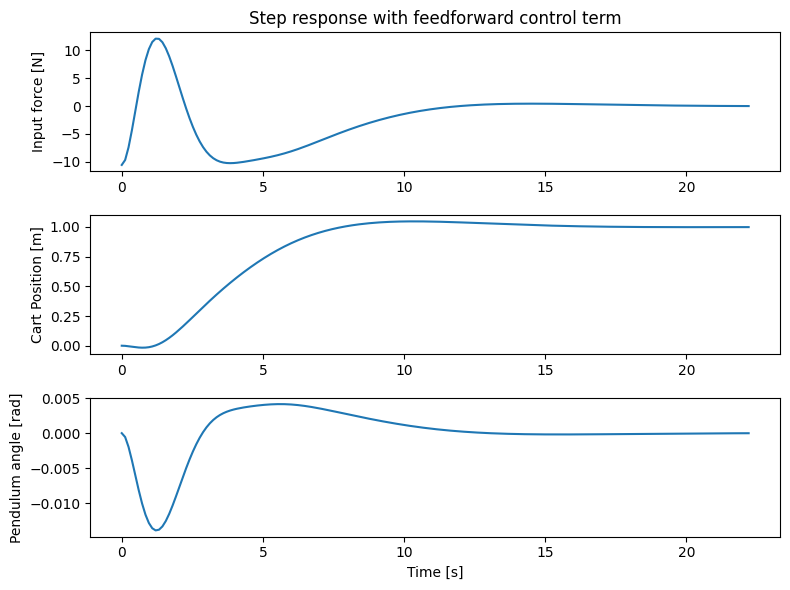

In [189]:
# the reference value for cart position [u=r]
r = 1

# compute the input force 
f_applied = -np.matmul(K[:,0:2], np.squeeze(yout_cff)) + k_f*r


# Plot the data
fig, axs = plt.subplots(3,1, figsize=(8, 6))

# input force 
axs[0].plot(T_cff.reshape(T_cff.size,1) , f_applied.T)

# cart position 
axs[1].plot(T_cff.reshape(T_cff.size,1), yout_cff[0].T)

# pendulum angle
axs[2].plot(T_cff.reshape(T_cff.size,1), yout_cff[1].T)

# Format the plot
axs[0].set_title("Step response with feedforward control term")

axs[0].set_ylabel('Input force [N]')
axs[1].set_ylabel('Cart Position [m]')
axs[2].set_ylabel('Pendulum angle [rad]')

axs[2].set_xlabel('Time [s]')

plt.tight_layout()

- The fast dynamics of the pendulum angle controller demand very high peal input force (>10 N). Also, the input force starts at negative 10N and quickly transitions to 10 N. Clearly, the demands placed on the actuator are unrealistic.  - So, we scale down the eigenvalues for the fast dyanmics by a factor of 3, but leave the damping ratio unchanged. Corrspondingly, the cart dynamics are also slowed down by relaxing the rise time requirements from 5s to 10s

In [190]:
# Scale down the pendulam dynamics eigenvallues by a factor of 3
pendulum_eig_2 = pendulum_eig/3.

# Compute desired eigenvalues for cart dynamics for rise time = 5s
c_t_rise = 10.

c_omega_n = 2.2/c_t_rise

# compute eigenvalues for the desired system  
coeff = [1., 2.*c_zeta*c_omega_n, c_omega_n**2]
cart_eig_2 = np.roots(coeff)

print("Desired eigenvalues for pendulum dynamics: ", pendulum_eig_2)
print("Desired eigenvalues for cart dynamics: ", cart_eig_2)

Desired eigenvalues for pendulum dynamics:  [-0.35+0.6j -0.35-0.6j]
Desired eigenvalues for cart dynamics:  [-0.16+0.16j -0.16-0.16j]


### LQR Controller

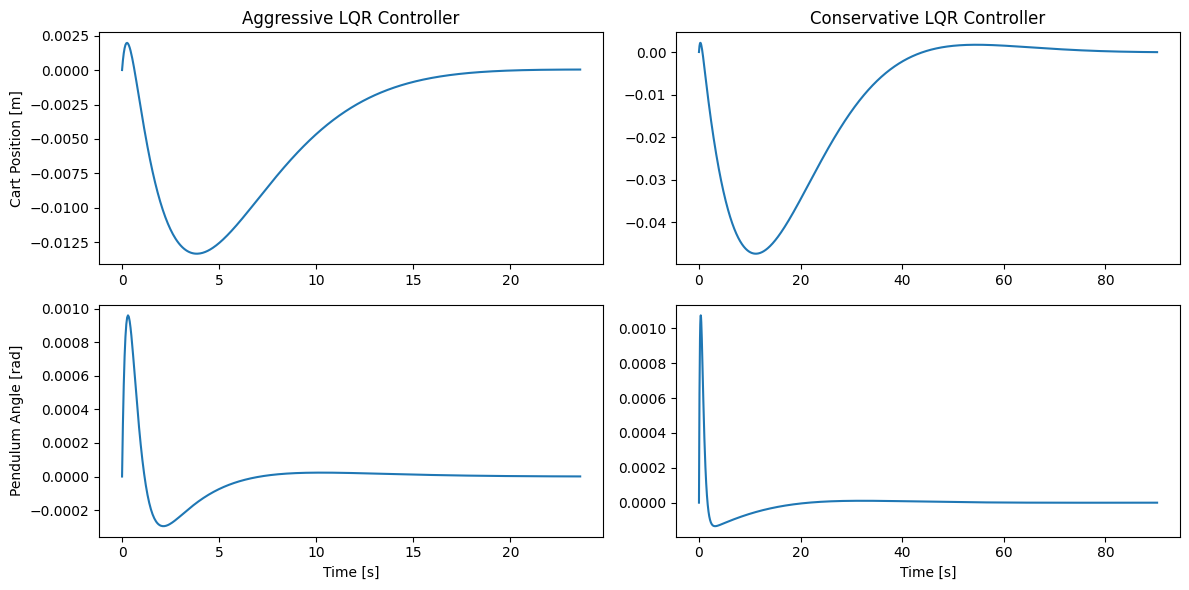

In [203]:
# LQR Controller 1: Aggressive
Q_x = np.diag([1, 1, 10, 100])
Q_u = np.diag([0.01])

K_lqr, S_lqr, E_lqr = ct.lqr(sys, Q_x, Q_u)

# compute new dynamics matrix with state feedback: (A-BK)
A_state_fb_lqr = A - np.matmul(B,K_lqr)

# controlled system
sys_c_lqr = ct.ss(A_state_fb_lqr,B,C,D)
T_c_lqr1, yout_c_lqr1 = ct.impulse_response(sys_c_lqr)


# LQR Controller 2: Conservative
Q_x = np.diag([1, 1, 10, 100])
Q_u = np.diag([1.])

K_lqr, S_lqr, E_lqr = ct.lqr(sys, Q_x, Q_u)

# compute new dynamics matrix with state feedback: (A-BK)
A_state_fb_lqr = A - np.matmul(B,K_lqr)

# controlled system
sys_c_lqr = ct.ss(A_state_fb_lqr,B,C,D)
T_c_lqr2, yout_c_lqr2 = ct.impulse_response(sys_c_lqr)

# Plot the data
fig, axs = plt.subplots(2,2,figsize=(12, 6))

# impulse reponse with LQR controller 1
axs[0,0].plot(T_c_lqr1.reshape(T_c_lqr1.size,1), yout_c_lqr1[0].T)
axs[1,0].plot(T_c_lqr1.reshape(T_c_lqr1.size,1), yout_c_lqr1[1].T)

# impulse reponse with LQR controller 2
axs[0,1].plot(T_c_lqr2.reshape(T_c_lqr2.size,1), yout_c_lqr2[0].T)
axs[1,1].plot(T_c_lqr2.reshape(T_c_lqr2.size,1), yout_c_lqr2[1].T)

# Format the plot
axs[0,0].set_title('Aggressive LQR Controller')
axs[0,0].set_ylabel('Cart Position [m]')
axs[1,0].set_ylabel('Pendulum Angle [rad]')
axs[1,0].set_xlabel('Time [s]')

axs[0,1].set_title("Conservative LQR Controller")
axs[1,1].set_xlabel('Time [s]')

plt.tight_layout()

### Adding Integral Action

In [204]:
# To be Implemented 

# State Estimation

### Check Observability

In [145]:
# # Only the cart position is measured
# C = np.array([[1, 0, 0, 0]])

# # Only the cart velocity is measured
# C = np.array([[0, 1, 0, 0]])

# # Only the pendulum angle is measured
# C = np.array([[0, 0, 1, 0]])

# # Only the pendulum angular velocity is measured
# C = np.array([[0, 0, 1, 0]])

# Cart position and the pendulum angle are measured
C = np.array([[1, 0, 0, 0], [0, 0, 0, 0]])

D = np.zeros((C.shape[0],1))

# controlled system
sys_c = ct.ss(A_state_fb,B,C,D)

# compute the controllability matrix
obsv_matrix = ct.obsv(A, C)

# check if the matrix is full row rank, ie, if rank(matrix)=number of rows
obsv_result = True if np.linalg.matrix_rank(obsv_matrix) == obsv_matrix.shape[1] else False
print('Is Observable: ',obsv_result)

Is Observable:  True


In [117]:
# compute the observability grammian
Wc = ct.gram(sys_c, 'o')

# volume of the observability grammian ellipsoid
print('Volume of observability grammian ellipsoid: ', np.linalg.det(Wc)) 

# eigenvalues of the observability grammian 
print('Eigenvalues of observability grammian: ', np.linalg.eigvals(Wc))

Volume of observability grammian ellipsoid:  5.520160220573895
Eigenvalues of observability grammian:  [4.11e+02 2.44e+00 3.89e-01 1.42e-02]


### Kalman filter